<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/labs/cs473_lab_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

# BYU CS 473 Lab Week 7

## Introduction:

For this lab, you will implement the Expectation Maximization algorithm on the Old Faithful dataset. This involves learning the parameters of a Gaussian mixture model. Your notebook should produce a visualization of the progress of the algorithm. The final figure could look something like this (they don't have to be arranged in subplots):

![final figure](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_7_image1.png)

---
## Grading standards   

Your notebook will be graded on the following:

* 10% Data is correctly mean-centered
* 20% Correctly updates responsibilities
* 20% Correctly updates means
* 20% Correctly updates covariances
* 20% Correctly updates mixing weights
* 10% Final plot(s) is/are tidy and legible

---
## Description

For this lab, we will be using the Expectation Maximization (EM) method to learn the parameters of a Gaussian mixture model. These parameters will reflect cluster structure in the data – in other words, we will learn probabilistic descriptions of clusters in the data.

For this lab, you will use the Old Faithful dataset, which you can download here:

[Old Faithful dataset](https://wingated.github.io/cs473/data/old_faithful.csv)

When loading the dataset, you should mean center the data to avoid division by zero in later steps.

The equations for implementing the EM algorithm are given in MLAPP 8.7.

The algorithm is:

1. Compute the responsibilities $r_nk$ (Eq. 8.160)
2. Update the mixing weights $\pi_k$ (Eq. 8.167)
3. Update the covariances $\Sigma_k$ (Eq. 8.166)
4. Update the means $\mu_k$ (Eq. 8.165)

Now, repeat until convergence. Note that if you change the order of operations, you may get slightly difference convergences than the reference image.

Since the EM algorithm is deterministic, and since precise initial conditions for your algorithm are given below, the progress of your algorithm should closely match the reference image shown above.

For your visualization, please print out at least nine plots. These should color each datapoint using $r_ik$ and they should plot the means and covariances of the Gaussians. See the hints section for how to plot an ellipse representing the 95% confidence interval of a Gaussian, given an arbitrary covariance matrix.

**Note: To help our TA better grade your notebook, you should use the following initial parameters:**

```python
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])

# the Gaussian covariance matrices
covs = list()
covs.append(
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append(
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )

# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called pi in the book
```

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
plt.style.use('seaborn-v0_8-darkgrid')

In [61]:
url = 'https://wingated.github.io/cs473/data/old_faithful.csv'
df = pd.read_csv(url)

# Convert the dataframe to a numpy array
data = df.to_numpy()

In [62]:
# calculate mean and sub mean from all data points
mean_data = np.mean(data, axis=0)
centered_data = data - mean_data


In [63]:
# data points and dimensions
n, d = centered_data.shape
# modeling this with k=2 Gaussian distributions
k=2

In [64]:
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])

# the Gaussian covariance matrices
covs = list()
covs.append(
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append(
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )

# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called pi in the book

In [65]:
def cov_to_pts(cov):
    circ = np.linspace(0, 2*np.pi, 100)
    sf = np.asarray([np.cos(circ), np.sin(circ)])
    [u, s, v] = np.linalg.svd(cov)
    pmat = u @ np.diag(2.447 * np.sqrt(s))
    return pmat @ sf

In [66]:
plt.figure(figsize=(12, 8))
plot_iterations = [1, 5, 9, 13, 17, 21, 25, 29, 33]
plot_idx = 1

<Figure size 1200x800 with 0 Axes>

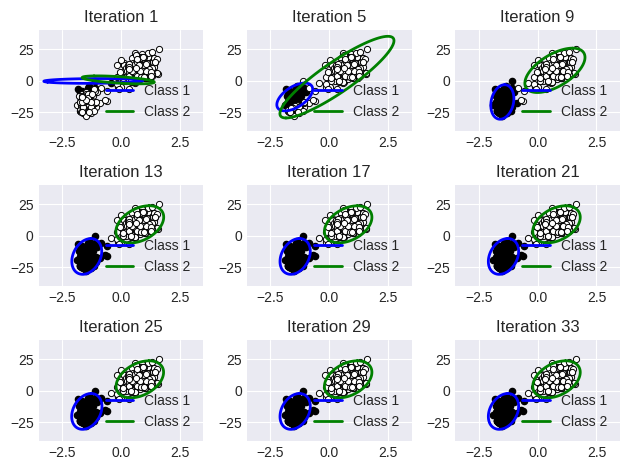

In [67]:
total_iterations = 34
ellipse_colors = ['blue', 'green']


for i in range(total_iterations):
    # Compute Responsibilities
    weighted_likelihoods = np.zeros((n, k))
    # Calculate the gausiian likelihood
    for j in range(k):
        likelihood = multivariate_normal.pdf(centered_data, mean=mus[:, j], cov=covs[j])
        weighted_likelihoods[:, j] = mws[j] * likelihood
    # Normalize to get responsibilities
    sum_of_likelihoods = np.sum(weighted_likelihoods, axis=1, keepdims=True)
    responsibilities = weighted_likelihoods / (sum_of_likelihoods + 1e-8)


    if i+1 in plot_iterations:
        ax = plt.subplot(3, 3, plot_idx)
        plot_idx += 1

        # Perform a "hard assignment" of each point to the most likely cluster
        hard_assignments = np.argmax(responsibilities, axis=1)

        # Plot points assigned to cluster 0 (Class 1) as black
        ax.scatter(centered_data[hard_assignments == 0, 0], centered_data[hard_assignments == 0, 1],
                   c='black', s=20, label='_nolegend_') # <<< CHANGE: Increased point size

        # Plot points assigned to cluster 1 (Class 2) as white with black edges
        ax.scatter(centered_data[hard_assignments == 1, 0], centered_data[hard_assignments == 1, 1],
                   facecolors='white', edgecolors='black', s=20, linewidth=0.7, label='_nolegend_') # <<< CHANGE: Increased point size


        # Plot the Gaussian ellipses
        for j in range(k):
            ellipse_pts = cov_to_pts(covs[j])
            ax.plot(ellipse_pts[0,:] + mus[0, j], ellipse_pts[1,:] + mus[1, j],
                    c=ellipse_colors[j], # Black color for ellipse
                    linewidth=2,label=f'Class {j+1}')

        ax.set_title(f'Iteration {i+1}')
        ax.legend()
        plt.xlim(-3.5, 3.5)
        plt.ylim(-40, 40)


    # Calculate the sum of responsibilities for each cluster
    r_sum = np.sum(responsibilities, axis=0)

    # Update Mixing Weights
    mws = r_sum / n

    # Update Means

    mus = (centered_data.T @ responsibilities) / r_sum

    # Update Covariances
    for j in range(k):
        diff = centered_data - mus[:, j]
        weighted_diff = diff * responsibilities[:, j, np.newaxis]
        covs[j] = (weighted_diff.T @ diff) / r_sum[j]

plt.tight_layout()
plt.show()

---
## Hints

In order to visualize a covariance matrix, you should plot an ellipse representing the 95% confidence bounds of the corresponding Gaussian. Here is some code that accepts as input a covariance matrix, and returns a set of points that define the correct ellipse; these points can be passed directly to the plt.plot() command as the x and y parameters.

In [ ]:
import numpy as np

def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

Here are some additional python functions that may be helpful to you:

In [ ]:
# compute the likelihood of a multivariate Gaussian
scipy.stats.multivariate_normal.pdf

# scatters a set of points; check out the "c" keyword argument to change color, and the "s" arg to change the size
plt.scatter
plt.xlim # sets the range of values for the x axis
plt.ylim # sets the range of values for the y axis

# to check the shape of a vector, use the .shape member
foo = np.random.randn( 100, 200 )
foo.shape # an array with values (100,200)

# to transpose a vector, you can use the .T operator
foo = np.atleast_2d( [42, 43] ) # this is a row vector
foo.T # this is a column vector

import numpy as np
np.atleast_2d
np.sum